## Multi-label text classification using BERT

In [ ]:
!nvidia-smi

In [ ]:
%pip install torch torchvision

In [ ]:
%pip install --upgrade transformers

In [4]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
import numpy as np
import json
import csv

df = pd.read_csv('./data/data_hub.csv')
df

,text,SDG-01,SDG-02,SDG-03,SDG-04,SDG-05,SDG-06,SDG-07,SDG-08,SDG-09,SDG-10,SDG-11,SDG-12,SDG-13,SDG-14,SDG-15,SDG-16,SDG-17
0,UNECE Releases 44 Recommended Climate Indicato...,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0
1,Largest Source of Lead Pollution Phased Out in...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,VNR Update: 15 Countries Planning to Participa...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,SDG Moment Will Provide Reality Check with Nin...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,"Biodiversity Framework Will Need Finance, Capa...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,UN Encourages Children to “Take Over” Among in...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
9168,COP 23 Presidency’s Grand Coalition Supports Y...,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1
9169,African Youth Take Action on Climate Change A ...,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1
9170,Generation 2030: Have Your Say The Generation ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
sample_size = 5000

# Subsample the data
df = df.sample(n = sample_size, random_state = 4)

In [7]:
df.head()

,text,SDG-01,SDG-02,SDG-03,SDG-04,SDG-05,SDG-06,SDG-07,SDG-08,SDG-09,SDG-10,SDG-11,SDG-12,SDG-13,SDG-14,SDG-15,SDG-16,SDG-17
3902,Five Countries Participating in South-South Tr...,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,1
410,Members Signal Preference for Ngozi Okonjo-Iwe...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1051,Investors Start Two-Year Push to Increase Supp...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8737,Agriculture in the 21st Century: New Landscape...,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0
8773,Strengthening Inclusive Thematic Reviews of th...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
from sklearn.model_selection import train_test_split

# split into train and test
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [9]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (3500, 18), Test: (750, 18), Valid: (750, 18)


In [10]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32

VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [11]:
from transformers import BertTokenizer, BertModel

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(
    test_text,
    add_special_tokens=True,
    max_length=50,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
    truncation=True 
)
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html)
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [14]:
df_train['text']

2750    Benin’s National Assembly Passes Climate Chang...
6222    UNIDO Launches Cleaner Production Programme in...
7313    EU-Africa Summit Outlines Actions on Peace and...
8358    Blue Food for Thought: Four New Ideas for Prot...
3415    Europe Forum Queries Investability of SDGs Not...
                              ...                        
3862    Pacific Island Leaders Sign Lofoten Declaratio...
5813    EBRD to Dedicate Next 25 Years to Green Econom...
1779    Report Urges Behavior Change for Nature Conser...
6787    UNCTAD Warns Against Restrictive Regional Trad...
6030    Green Finance Event Considers Role of Private ...
Name: text, Length: 3500, dtype: object

In [15]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.text = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'text': text
        }

In [16]:
target_list = list(df.columns)
target_list

['text',
 'SDG-01',
 'SDG-02',
 'SDG-03',
 'SDG-04',
 'SDG-05',
 'SDG-06',
 'SDG-07',
 'SDG-08',
 'SDG-09',
 'SDG-10',
 'SDG-11',
 'SDG-12',
 'SDG-13',
 'SDG-14',
 'SDG-15',
 'SDG-16',
 'SDG-17']

In [17]:
target_list = target_list[1:]

In [18]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)


In [19]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101, 21164,  1521,  1055,  2120,  3320,  5235,  4785,  2689,  6094,
          2120,  4785,  2689,  6094,  4233,  1999, 21164,  5942,  2008,  1010,
          2183,  2830,  1010,  2035,  2120,  1011,  1998,  2334,  1011,  2504,
          2458,  9942,  1998,  8497, 13265,  4785,  2689,  1012,  1996,  4785,
          3021,  4233,  1999,  2238,  2760,  2003,  2028,  1997,  1996,  2364,
          3463,  1997,  1037,  5386,  2090,  6151,  2361,  1998,  1996,  2231,
          1997, 21164,  1010,  1999,  5792,  2007,  1996,  2897,  1997, 21164,
          3323, 28369,  2006,  4785,  2689,  1998,  9084,  2458,  1012,  2654,
          2238,  2760,  1024, 21164,  1521,  1055,  2120,  3320,  2038,  2979,
          4785,  2689,  6094,  1010,  2437,  2009,  2028,  1997,  1996,  2034,
          3032,  2000, 11092,  2107,  6094,  1012,  2183,  2830,  1010,  1996,
          6094,  2003,  3517,  2000,  2393, 21164,  4652,  1010,  4047,  2114,
          1998,  6133,  1996,  8465,  1

In [20]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [21]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 17)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [22]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [23]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

c:\Users\DESKTOP\anaconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:

# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [25]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [26]:
data_dir = "./"

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        
        model_save_path = os.path.join(data_dir, "output")
        os.makedirs(model_save_path, exist_ok=True)

        # model save
        model_save_file = os.path.join(model_save_path, "best_model_state.pt")
        torch.save(model.state_dict(), model_save_file)
        print(f"Model saved to {model_save_file}")
        best_accuracy = val_acc

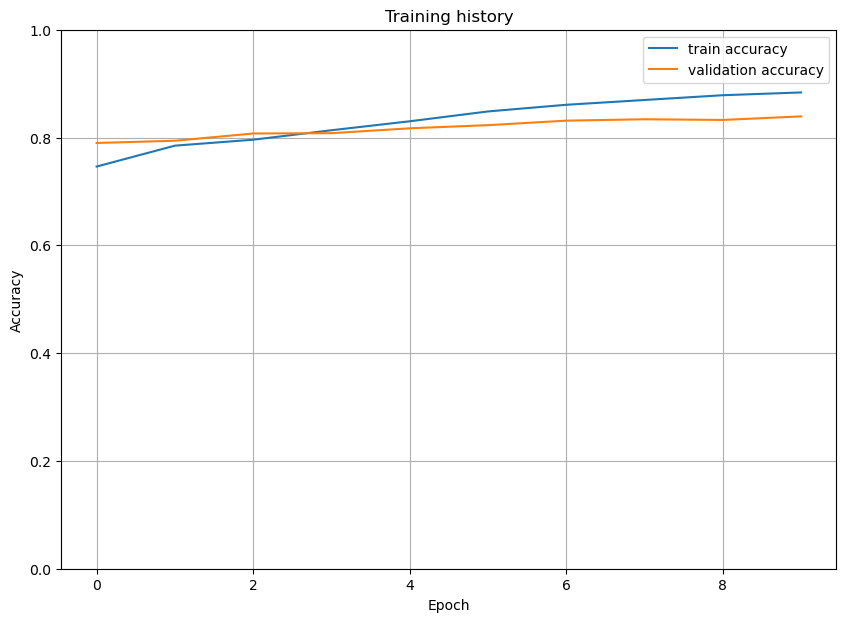

In [29]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Evaluation of the Model

In [30]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"output","best_model_state.bin")))
model = model.to(device)

In [31]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [32]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.8376470588235294

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    texts = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        texts = data["text"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return texts, predictions, prediction_probs, target_values

In [35]:
texts, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [36]:
# sanity check
predictions.numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [37]:
print(f"titles:{len(texts)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")
     

titles:28 
predictions:torch.Size([750, 17]) 
prediction_probs:torch.Size([750, 17]) 
target_values:torch.Size([750, 17])


In [38]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

      SDG-01       0.66      0.51      0.58       187
      SDG-02       0.66      0.28      0.40       162
      SDG-03       0.76      0.30      0.43       172
      SDG-04       0.60      0.24      0.34        89
      SDG-05       0.69      0.38      0.49       145
      SDG-06       0.69      0.32      0.44       128
      SDG-07       0.69      0.53      0.60       146
      SDG-08       0.58      0.30      0.39       157
      SDG-09       0.54      0.26      0.35       129
      SDG-10       0.62      0.48      0.54       154
      SDG-11       0.64      0.26      0.37       124
      SDG-12       0.74      0.26      0.38       136
      SDG-13       0.83      0.75      0.79       303
      SDG-14       0.69      0.40      0.51       108
      SDG-15       0.76      0.51      0.61       171
      SDG-16       0.67      0.37      0.48       150
      SDG-17       0.76      0.68      0.72       361

   micro avg       0.71   

c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Predicting on raw text

In [64]:
raw_text = "UN Forum concludes with urgent call for nations to scale up development cooperation to better support the most vulnerable"

In [65]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    padding='longest',
    return_attention_mask=True,
    return_tensors='pt',
)    

In [66]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.1
output = output.flatten().round().numpy()
output

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [67]:
# Correctly identified the topic of the paper: High energy physics
print(f"texts: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")

texts: UN Forum concludes with urgent call for nations to scale up development cooperation to better support the most vulnerable
Label: SDG-17
